# Optimization of an ensemble state-to-state transfer in a Lambda system

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import qutip
from qutip import Qobj
import pickle
%watermark -v --iversions

numpy            1.15.4
scipy            1.2.0
matplotlib.pylab 1.15.4
krotov           0.3.0+dev
matplotlib       3.0.2
qutip            4.3.1
CPython 3.6.8
IPython 7.2.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{Ketbra}[2]{\left\vert#1\vphantom{#2}
\right\rangle \hspace{-0.2em} \left\langle #2\vphantom{#1} \right\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
\newcommand{toP}[0]{\omega_{12}}
\newcommand{toS}[0]{\omega_{23}}$

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{Ketbra}[2]{\left\vert#1\vphantom{#2}
\right\rangle \hspace{-0.2em} \left\langle #2\vphantom{#1}\right\vert}
\newcommand{e}[1]{\mathrm{e}^{#1}}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
\newcommand{toP}[0]{\omega_{12}}
\newcommand{toS}[0]{\omega_{23}}
\newcommand{oft}[0]{\left(t\right)}$
This notebook should illustrate how to use krotov's `krotov.objectives.ensemble_objectives` function, which can be used to create an ensemble of objectives with different Hamiltonians. Using this, it is possible to achieve more robust optimization results.  
The system under consideration is the Lambda system as defined in the [second example notebook](02_example_lambda_system_rwa_complex_pulse.ipynb).

## Define the Hamiltonian

The energylevels of our system are illustrated below (picture inspired by ["Introduction to Quantum Mechanics: A Time-Dependent Perspective" by David Tannor](http://www.weizmann.ac.il/chemphys/tannor/Book/))
<img src="energylevels.png" alt="Lambda system considered in this notebook" width="500">

As mentioned in the second example, these levels interact with two pulses with the base frequency $\omega_{\mathrm{P}}$ ("Pump"-pulse) and $\omega_{\mathrm{S}}$ ("Stokes"-pulse), respectively. The pulses have time-dependent envelopes 
\begin{align*}
\epsilon_{\mathrm{P}}(t) &= \frac{\Omega_{\mathrm{P}}^{(1)}(t)}{\mu_{12}}\cos({\omega_{\mathrm{P}}}t)
                           +\frac{\Omega_{\mathrm{P}}^{(2)}(t)}{\mu_{12}}\sin({\omega_{\mathrm{P}}}t) \\
\epsilon_{\mathrm{S}}(t) &= \frac{\Omega_{\mathrm{S}}^{(1)}(t)}{\mu_{23}}\cos({\omega_{\mathrm{S}}}t)
                           +\frac{\Omega_{\mathrm{S}}^{(2)}(t)}{\mu_{23}}\sin({\omega_{\mathrm{S}}}t),
\end{align*}
With the coupling strength $\mu_{ij}$ between the levels $i$ and $j$.
The frequencies are chosen, such that they are close to the transition frequencies $\ket{1}\rightarrow\ket{2}$ ($\omega_{12}$) and $\ket{3} \rightarrow\ket{2}$ ($\omega_{32}$).
By using the RWA, we obtain the Hamiltonian 

\begin{equation*}
\hat{H} =  \hbar \begin{pmatrix}
-\Delta_{\mathrm{P}} & \Omega^{\ast}_{\mathrm{P}}(t) & 0 \\
\Omega_{\mathrm{P}}(t) & 0 & \Omega^{\ast}_{\mathrm{S}}(t) \\
0 & \Omega_{\mathrm{S}}(t) & -\Delta_{\mathrm{S}}
\end{pmatrix},
\end{equation*}
with $\Delta_{\mathrm{P}} = E_1 + \omega_{\mathrm{P}} - E_2$ and $\Delta_{\mathrm{S}} = E_3 + \omega_{\mathrm{S}} - E_2$.
The envelopes become complex with $\Omega_{\mathrm{P}} = \Omega^{(1)}_{\mathrm{P}} + i\Omega^{(2)}_{\mathrm{P}}$ and $\Omega_{\mathrm{S}} = \Omega^{(1)}_{\mathrm{S}} + i\Omega^{(2)}_{\mathrm{S}}$.

In the following, we will optimize the real and imaginary part of $\Omega_{\mathrm{S}}$ and $\Omega_{\mathrm{P}}$ independently. 

In some experiments, the amplitude of the laser might fluctuate and vary around the desired one. Therefore, we would like to make the optimization more robust against the fluctuation of the pulse amplitude. To create a set of Hamiltonians with varying coupling strengths, we add an additional factor to the function, returning the Hamiltonian:


In [2]:
T = 5.

def ham_and_states(coupling_strength_fac=1.):
    """Lambda-system Hamiltonian"""
    E1 = 0.
    E2 = 10.
    E3 = 5.
    ω_P = 9.5
    ω_S = 4.5
    Ω_init = 5.
    H0 =  Qobj([[E1+ω_P-E2, 0., 0.], \
                [0., 0., 0.],        \
                [0., 0., E3+ω_S-E2]])
    
        
    H1P_re = -coupling_strength_fac*0.5*Qobj([[0.,1.,0.], [1.,0.,0.],[0.,0.,0.]])    
    H1P_im = -coupling_strength_fac*0.5*Qobj([[0.,1.j,0.],[-1.j,0.,0.],[0.,0.,0.]])
    ΩP_re = lambda t, args: Ω_init
    ΩP_im = lambda t, args: Ω_init
    
    H1S_re = -coupling_strength_fac*0.5*Qobj([[0.,0.,0.],[0.,0.,1.],[0.,1.,0.]])
    H1S_im = -coupling_strength_fac*0.5*Qobj([[0.,0.,0.],[0.,0.,1.j],[0.,-1.j,0.]])
    ΩS_re = lambda t, args: Ω_init    
    ΩS_im = lambda t, args: Ω_init
    
    """Initial and target states"""
    psi0 = qutip.Qobj(np.array([1.,0.,0.]))
    psi1 = qutip.Qobj(np.array([0.,0.,1.]))    
    
    #State transformation to the rotating frame
    psi1 *= np.exp(1j * (E2 - ω_S) * T)
    
    return ([H0, \
            [H1P_re, ΩP_re], [H1P_im, ΩP_im], \
            [H1S_re, ΩS_re], [H1S_im, ΩS_im]], \
            psi0, psi1)

H, psi0, psi1 = ham_and_states()

The following steps are in general the same as in the second example

---

We introduce projectors for each of the three energy levels
$\op{P}_{i} =
\Ketbra{i}{i}$

In [3]:
proj1 = Qobj([[1.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
proj2 = Qobj([[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]])
proj3 = Qobj([[0.,0.,0.],[0.,0.,0.],[0.,0.,1.]])

## Define the optimization target

In the following we consider dynamics acting
over a duration of $\Delta_{t} = 5$, beginning at
$t_{0} = 0$ and ending at $T =
\Delta_{t}$. 
The time grid is divided into $n_{t} = 500$ equidistant time
steps.

In [4]:
t0 = 0.
nt = 500
tlist = np.linspace(t0, T, nt)

We define the objective to be a state to state transfer from the initial state
$\Ket{\Psi_{\init}} = \Ket{1}$ into the final state $\Ket{\Psi_{\tgt}} =
\Ket{3}$ at the
final time $t_{f}$.

In [5]:
objectives = [ krotov.Objective(initial_state=psi0, target=psi1, H=H) ]

## Initial guess shapes

"stimulated Raman adiabatic passage" (STIRAP) is a
process in which population in $\Ket{1}$ is transferred into
$\Ket{3}$ without
having to pass through $\Ket{2}$ (which could for instance be a rapidly decaying
level).
In order for this process to occur, a temporally finite Stokes pulse of
sufficient amplitude driving the $\Ket{2} \leftrightarrow \Ket{3}$ transition is
applied first, whilst second pump pulse of similar intensity follows some time
later such that the pulses still have a partial temporal overlap.

In order to
demonstrate the Krotov's optimization method however, we choose an initial guess
consisting of two low intensity and real Blackman pulses which are temporally
disjoint.

For the real components of the matrix elements, we supply our guess
pulses shaped as Blackman window functions `S(t,offset)`, with an offset
ensuring that the two pulses don't overlap.
The imaginary components are coupled
to pulses that are zero at all times.

In [6]:
def S(t,offset):
    """Shape envelope function for the field update"""
    return krotov.shapes.blackman(t,1.+offset,4.+offset)

def shape_field_real(eps,offset):
    """Applies the total pulse shape to the real part of a guess pulse"""
    field_shaped = lambda t, args: eps(t, args)*S(t,offset)
    return field_shaped

def shape_field_imag(eps,offset):
    """Initializes the imaginary parts of the guess pulses to zero"""
    field_shaped = lambda t, args: eps(t, args)*0.
    return field_shaped

H[1][1] = shape_field_real(H[1][1],1.)
H[2][1] = shape_field_imag(H[2][1],1.)
H[3][1] = shape_field_real(H[3][1],-1.)
H[4][1] = shape_field_imag(H[4][1],-1.)

We choose an appropriate update factor $\lambda_{a}$ for the problem at hand and
make sure Krotov considers pulses which start and end with zero amplitude.

In [7]:
def update_shape(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(t,0.,T,0.3,func='sinsq')

In [8]:
opt_lambda = .0020
pulse_options = {
    H[1][1]: dict(lambda_a=opt_lambda, shape=update_shape),
    H[2][1]: dict(lambda_a=opt_lambda, shape=update_shape),
    H[3][1]: dict(lambda_a=opt_lambda, shape=update_shape),
    H[4][1]: dict(lambda_a=opt_lambda, shape=update_shape),
}

## Setting the ensemble objectives

Up to this point, everything was very similar to the second example notebook.
However, as mentioned above, we would like to obtain more robust pulses with respect to pulse amplitude fluctuations.
Therefore, we use the `krotov.objectives.ensemble_objectives` function.
This functions takes an ensemble of Hamiltonians, which we create in the following

In [9]:
ham_ensemble=[]

for coupl in np.arange(.90,1.11,.1): 
    if coupl == 1.:
        continue
    # 1. Creating the Hamiltonian, which will be part of the ensemble
    singele_ensemble_hamiltonian,_,_ = ham_and_states(coupling_strength_fac=coupl)
    
    # 2. Linking the pulses of the Hamiltonians to those of the original one
    singele_ensemble_hamiltonian[1][1] = H[1][1] #  left atom blue
    singele_ensemble_hamiltonian[2][1] = H[2][1] #  left atom red
    singele_ensemble_hamiltonian[3][1] = H[3][1] # right atom blue
    singele_ensemble_hamiltonian[4][1] = H[4][1] # right atom red
            
    # 3. Adding the Hamiltonian to the overall ensemble
    ham_ensemble.append(singele_ensemble_hamiltonian)
        

The creation of the hamiltonian ensemble has (in our case) three main parts:
1. The creation of the Hamiltonian, where we used our function defined above and pass it the parameter we would like to vary
2. Since we want to use the same pulses to optimize all Hamiltonians, we need to make sure, that the pulses of the new Hamiltonians are the same as those of the original one. We do this by assiging the pulses of `H` to the ensemble Hamiltonian in the second step
3. Finally we add the Hamiltonian with the original pulses to the ensemble

*Note: We ommit the parameter with `coupl==1.`, since this is the case of the original objective defined further above. This will also be added to the ensemble. If we would not do this, we would have this Hamiltonian twice in our ensemble objectives.*

After having defined our Hamiltonian ensemble, we can now finally create our ensemble of objectives

In [10]:
ensemble_objectives = krotov.objectives.ensemble_objectives(objectives, ham_ensemble)
ensemble_objectives

[Objective[|(3)⟩ - {[Herm[3,3], [Herm[3,3], u1(t)], [Herm[3,3], u2(t)], [Herm[3,3], u3(t)], [Herm[3,3], u4(t)]]} - |(3)⟩],
 Objective[|(3)⟩ - {[Herm[3,3], [Herm[3,3], u1(t)], [Herm[3,3], u2(t)], [Herm[3,3], u3(t)], [Herm[3,3], u4(t)]]} - |(3)⟩],
 Objective[|(3)⟩ - {[Herm[3,3], [Herm[3,3], u1(t)], [Herm[3,3], u2(t)], [Herm[3,3], u3(t)], [Herm[3,3], u4(t)]]} - |(3)⟩]]

As you can see, we have here a list of different objectives, each containing a Hamiltonian coupling to the same pulse.

## Optimize

We now supply Krotov with all the information it needs to optimize,
consisting of the `objectives` (maximize population in $\Ket{3}$ at $t_{1}$),
`pulse_options` (the initial shapes of our pulses and how they may be changed)
as well as the `propagator` to use, optimization functional (`chi_constructor`),
`info_hook` (processing occuring inbetween iterations of optimization) and the
maximum number of iterations to perform, `iter_stop`. We will stop the
optimization when the error goes below $10^{-3}$ or the fidelity has converged
to within 5 digits.

Since we have a list with multiple objectives, we can use the `parallel_map` argument in the recommended version, to parallelize our propagations.

**Note:** We cheated a little with the $\lambda_a$ parameter and set it to a very small value. This will result in very large pulse amplitude. However, this is much faster and therefore neat for the purpose of illustration. If you need smaller amplitudes, choose $\lambda_a$ bigger and set the iter_stop to a higher value.

In [11]:
oct_result = krotov.optimize_pulses(
    ensemble_objectives,
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_re,
        show_g_a_int_per_pulse=True,
        unicode=True,
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.delta_below(1e-5),
        krotov.convergence.check_monotonic_error,
    ),
    parallel_map=(
        qutip.parallel_map,
        qutip.parallel_map,
        krotov.parallelization.parallel_map_fw_prop_step,
    ),
    iter_stop=15,
)

  iter.        J_T   ∫gₐ(ϵ1)dt   ∫gₐ(ϵ2)dt   ∫gₐ(ϵ3)dt   ∫gₐ(ϵ4)dt   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
      0   1.01e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00   1.01e+00        n/a        n/a     1
      1   1.15e-02    8.44e+01    1.91e+00    1.46e+02    1.06e+01    2.43e+02   2.43e+02  -9.97e-01   2.42e+02     7 *
      2   7.68e-03    2.13e-01    6.36e-02    2.53e-01    3.22e-02    5.62e-01   5.70e-01  -3.82e-03   5.59e-01     7 *
      3   5.67e-03    1.02e-01    2.92e-02    1.10e-01    2.52e-02    2.67e-01   2.72e-01  -2.01e-03   2.65e-01     7 *
      4   4.41e-03    5.41e-02    2.87e-02    5.14e-02    2.39e-02    1.58e-01   1.62e-01  -1.26e-03   1.57e-01     6 *
      5   3.52e-03    3.04e-02    2.85e-02    2.33e-02    2.37e-02    1.06e-01   1.09e-01  -8.92e-04   1.05e-01     7 *
      6   2.83e-03    1.74e-02    2.71e-02    1.02e-02    2.30e-02    7.77e-02   8.06e-02  -6.84e-04   7.70e-02     7 *
      7   2.29e-03    1.01e-02    2.45e-02  

In [12]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2019-03-18 18:03:28
- Number of objectives: 3
- Number of iterations: 12
- Reason for termination: Reached convergence: J_T < 0.001
- Ended at 2019-03-18 18:04:57

We appear to have found pulse-shapes that fulfill our objective, but what do
they look like?

pump pulse amplitude and phase:


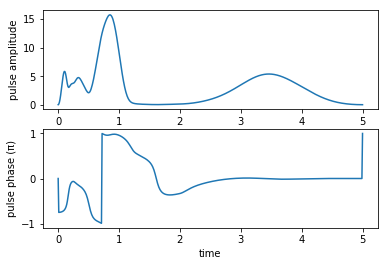

Stokes pulse amplitude and phase:


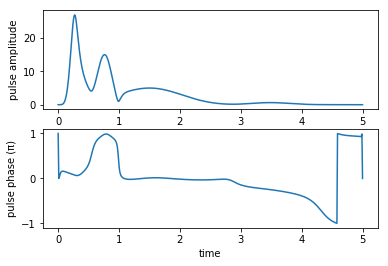

In [13]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')    
    plt.show()
    
print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist)

Once we have the optimized real and imaginary parts of the $\Omega_P (t)$ and $\Omega_P (t)$ functions we can retrieve the physical pulses $\varepsilon _P (t)$ and $\varepsilon _S (t)$ using their very definition. 

Physical electric pump pulse in the lab frame:


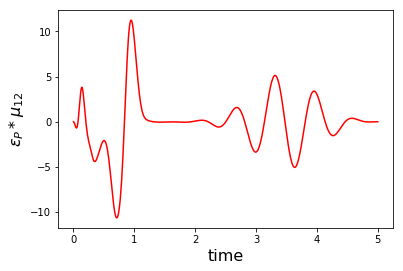

Physical electric Stokes pulse in the lab frame:


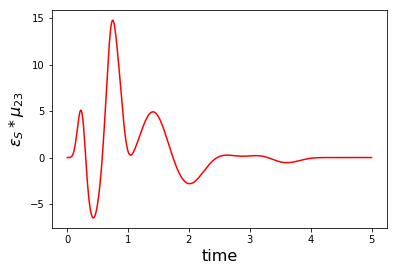

In [14]:
def plot_physical_field(pulse_re, pulse_im, tlist, case=None):

    if case == 'pump':
        w = 9.5
    elif case == 'stokes':
        w = 4.5
    else: 
        print('Error: selected case is not a valid option')
        return
    
    ax = plt.subplot(111)    
    ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
    ax.set_xlabel('time', fontsize = 16)
    if case == 'pump':
        ax.set_ylabel(r'$\varepsilon_{P} * \mu_{12}$', fontsize = 16)
    elif case == 'stokes':
        ax.set_ylabel(r'$\varepsilon_{S} * \mu_{23}$', fontsize = 16)
    plt.show()
    
print('Physical electric pump pulse in the lab frame:')
plot_physical_field(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist, case = 'pump')


print('Physical electric Stokes pulse in the lab frame:')
plot_physical_field(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist, case = 'stokes')

### Robustness analysis

Finally, we take a look on the propagated results for different pulse amplitudes.
For this, we define the following function which propagates the Hamiltpnian with a specific coupling under the optimized pulse.

In [15]:
def solve_under_opt_pulse(coupling):
    ensemble_hamiltonian,_,_ =  ham_and_states(coupling_strength_fac=coupling)
    
    ensemble_hamiltonian[1][1] = oct_result.optimized_controls[0] #  left atom blue
    ensemble_hamiltonian[2][1] = oct_result.optimized_controls[1] #  left atom red
    ensemble_hamiltonian[3][1] = oct_result.optimized_controls[2] # right atom blue
    ensemble_hamiltonian[4][1] = oct_result.optimized_controls[3] # right atom red
    
    
    return qutip.mesolve(ensemble_hamiltonian,psi0,tlist)

This function can now be mapped via `qutip.parallel_map`, which applies the functions in parallel.

In [16]:
import warnings
warnings.filterwarnings(action='ignore')
###
coupl = np.arange(.75,1.251,.0333333)
res = qutip.parallel_map(solve_under_opt_pulse, coupl)

Finally, we plot the final population of $\ket{3}$ with respect to the coupling parameter.

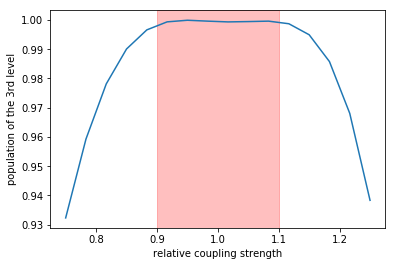

In [17]:
pops = []

for r in res:
    pops.append(qutip.expect(proj3, r.states[-1]))

fig,ax = plt.subplots()
ax.plot(coupl, pops)
ax.set_xlabel("relative coupling strength")
ax.set_ylabel("population of the 3rd level")
ax.axvspan(.9, 1.1, alpha=0.25, color='red')

We find, that the result indeed shows a plateau in the region, where we took the ensemble of Hamiltonians from (red area). 